![NYC Skyline](img/nyc.jpg)

Welcome to New York City, one of the most-visited cities in the world. There are many [Airbnb](https://www.airbnb.com/) listings in New York City to meet the high demand for temporary lodging for travelers, which can be anywhere between a few nights to many months. In this notebook, we will take a closer look at the New York Airbnb market by combining data from multiple file types like `.csv`, `.tsv`, and `.xlsx`.

Recall that **CSV**, **TSV**, and **Excel** files are three common formats for storing data. 
Three files containing data on 2019 Airbnb listings are available to you:

**data/airbnb_price.csv**
- **`listing_id`**: unique identifier of listing
- **`price`**: nightly listing price in USD
- **`nbhood_full`**: name of borough and neighborhood where listing is located

**data/airbnb_room_type.xlsx**
This is an Excel file containing data on Airbnb listing descriptions and room types.
- **`listing_id`**: unique identifier of listing
- **`description`**: listing description
- **`room_type`**: Airbnb has three types of rooms: shared rooms, private rooms, and entire homes/apartments

**data/airbnb_last_review.tsv**
This is a TSV file containing data on Airbnb host names and review dates.
- **`listing_id`**: unique identifier of listing
- **`host_name`**: name of listing host
- **`last_review`**: date when the listing was last reviewed

Our goals are to convert untidy data into appropriate formats to analyze, and answer key questions including:

- What is the average price, per night, of an Airbnb listing in NYC?
- How does the average price of an Airbnb listing, per month, compare to the private rental market?
- How many adverts are for private rooms?
- How do Airbnb listing prices compare across the five NYC boroughs?


In [447]:
# We've loaded your first package for you! You can add as many cells as you need.
import numpy as np
import pandas as pd
import datetime as dt
print("I'm loaded")

I'm loaded


In [448]:
airbnb_price = pd.read_csv("data/airbnb_price.csv")
airbnb_room = pd.read_excel("data/airbnb_room_type.xlsx")
airbnb_host = pd.read_csv("data/airbnb_last_review.tsv", sep= '\t')
print("I'm done")

I'm done


In [449]:
airbnb_full = airbnb_price.merge(airbnb_room, how='outer', on='listing_id')
airbnb_full = airbnb_full.merge(airbnb_host, how='outer', on='listing_id')
print("I've merged")

I've merged


In [450]:
#Check for nulls and duplicated rows
print(airbnb_full.isnull().sum())
print(airbnb_full.duplicated().value_counts())

listing_id      0
price           0
nbhood_full     0
description    10
room_type       0
host_name       8
last_review     0
dtype: int64
False    25209
dtype: int64


In [451]:
#As the nulls are in unimportant categories, it might not be necessary to drop them. We can ignore them if we choose. However, with a large dataset of over 25,000 rows, I believe we can safely drop them without impacting the veracity of the final numbers
full_drop_null = airbnb_full.dropna()

In [452]:
#Let's clean up the columns. We need to fix the Price column to eliminate the string of letters and change its type to integer. In addition, we should change the last_review column to a datetime and change the room type case to lower, as there are different type cases that will lead to issues later on if we work with that column
full_drop_null['price'] = full_drop_null['price'].str.replace(' dollars', '').astype(int)
full_drop_null['last_review'] = pd.to_datetime(full_drop_null['last_review'])
full_drop_null['room_type'] = full_drop_null['room_type'].str.lower()

In [453]:
#Let's look at the summary statistics for the price column to double check we're not missing anything concerning
print(full_drop_null.price.describe())


count    25191.000000
mean       141.816998
std        147.389669
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       7500.000000
Name: price, dtype: float64


In [454]:
#Huh, there are some listings with a nightly price of $0. That doesn't seem right, let's eliminate those. Looking at the maximum values shows that $7500 is also a bit high. However, let's take a quick graphical look at it.
full_drop_null = full_drop_null.loc[full_drop_null['price']!=full_drop_null['price'].min()]

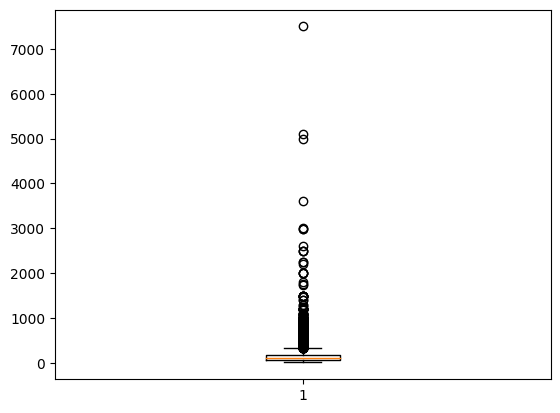

In [455]:
import matplotlib.pyplot as plt
fig = plt.boxplot(full_drop_null['price'])

While the maximum value of $7,500 is an outlier, it appears as though there are a significant number of outliers, some with very high values. While I feel that it could be skewing the mean a bit, I don't believe it's an erroneous figure. In an area with many values greater than $2,000 a night, $7,500 does not appear impossible or even improbable. I will keep it acknowledging that the mean is going to be pulled higher because of the higher values.

In [456]:
#The first thing we need to find is the average price, per night, of a listing in NYC.
avg_price = round(full_drop_null['price'].mean(), 2)

In [457]:
#In order to get the cost per month, we need to take the listing price, multiply it by 365, and divide it by 12 months. Once we have the cost for each rental on a monthly basis, we can take the average of those to get the average price per month.
full_drop_null['prices_per_month'] = (full_drop_null['price']*365)/12
average_price_per_month = round(full_drop_null['prices_per_month'].mean(),2)


In [458]:
#According to Zumper, the average cost of a one-bedroom apartment in NYC is $3,100 a month. How does the cost of an AirBnb rental compare to a traditional rental on a monthly basis?

difference = round(average_price_per_month - 3100, 2)

#It's also helpful to discover the first and last reviews so we can determine what time frame we're dealing with. 
first_reviewed = full_drop_null['last_review'].min()
last_reviewed = full_drop_null['last_review'].max()


In [459]:
#The next thing it asks for is the number of private rooms available. To do this, count the room_type column.
room_frequencies = full_drop_null['room_type'].value_counts()
room_frequencies

entire home/apt    13262
private room       11337
shared room          585
Name: room_type, dtype: int64

In [460]:
#Finally, it asks for a comparison of prices across all of the boroughs. Since the neighborhood column has the borough attached, we'll need to separate them.
full_drop_null[['borough', 'nbhood']] = full_drop_null['nbhood_full'].str.split(',', 1, expand=True)

#Let's find the average prices per borough
avg_prices_by_borough = round(full_drop_null.groupby('borough')['price'].mean(), 2)
print(avg_prices_by_borough)

borough
Bronx             79.25
Brooklyn         122.02
Manhattan        184.04
Queens            92.83
Staten Island     86.04
Name: price, dtype: float64


In [461]:
#Now let's create some ranges of values to classify the prices -- budget, average, expensive, and extravagent. 
full_drop_null['price'].quantile([0.25, 0.5, 0.75])


0.25     69.0
0.50    105.0
0.75    175.0
Name: price, dtype: float64

In [462]:
#Looking at the quantiles can give us a good idea of where the prices should be split for classification. Considering the wide range of pricing, Budget should be classified below the 1st quartile (<69), Average 69 - 175 (the IQR), Expensive 175 - 334 (roughly 1.5x the IQR), and Extravagent representing the outliers (anything above 1.5xIQR). This can allow us to compare the mean price in each borough and the number of listings grouped into the price classifications.

label_names= ["Budget", "Average", "Expensive", "Extravagent"]
ranges = [0, 69, 175, 334, np.inf]
full_drop_null['price_range'] = pd.cut(full_drop_null.price, ranges, labels = label_names,include_lowest = True, right=False)

prices_by_borough = full_drop_null.groupby('borough')['price_range'].value_counts()


In [463]:
#Finally, we'll create a dictionary to store our results for final interpretation.
airbnb_analysis = {'avg_price': avg_price, 
                   'average_price_per_month': average_price_per_month, 
                   'difference': difference, 
                   'room_frequencies': room_frequencies, 
                   'first_reviewed': first_reviewed, 
                   'last_reviewed': last_reviewed, 
                   'average_price_by_borough': avg_prices_by_borough,
                   'prices_by_borough': prices_by_borough}

In [464]:
print(airbnb_analysis)

{'avg_price': 141.86, 'average_price_per_month': 4314.8, 'difference': 1214.8, 'room_frequencies': entire home/apt    13262
private room       11337
shared room          585
Name: room_type, dtype: int64, 'first_reviewed': Timestamp('2019-01-01 00:00:00'), 'last_reviewed': Timestamp('2019-07-09 00:00:00'), 'average_price_by_borough': borough
Bronx             79.25
Brooklyn         122.02
Manhattan        184.04
Queens            92.83
Staten Island     86.04
Name: price, dtype: float64, 'prices_by_borough': borough        price_range
Bronx          Budget          372
               Average         290
               Expensive        28
               Extravagent       6
Brooklyn       Average        5462
               Budget         3099
               Expensive      1564
               Extravagent     326
Manhattan      Average        5194
               Expensive      3096
               Budget         1067
               Extravagent     958
Queens         Budget         1590
    